#Download necessary libraries

In [0]:
!pip install vadersentiment
!pip install lxml
!pip install beautifulsoup4

#Scrape Tweets and get Sentiment Scores


No more tweets returned
Gathered 804 Tweets


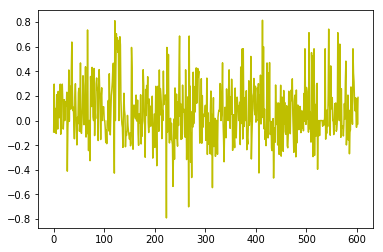

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import bs4 as bs
import urllib.request
import requests
import json
from bs4 import BeautifulSoup

twitter_handle = 'realdonaldtrump'

analyser = SentimentIntensityAnalyzer()

source = urllib.request.urlopen('https://twitter.com/' + twitter_handle).read()
soup = bs.BeautifulSoup(source,'lxml')
tweets = soup.findAll('p','tweet-text')
time_stamps = soup.findAll('span','_timestamp')

#################################
#Get Tweets on following pages
###################################
next_pointer = soup.find("div", {"class": "stream-container"})["data-min-position"]
count = 0
while count < 100:
  count +=1
  next_url = "https://twitter.com/i/profiles/show/" + twitter_handle + \
              "/timeline/tweets?include_available_features=1&" \
              "include_entities=1&max_position=" + next_pointer + "&reset_error_state=false"

  next_response = None
  try:
      next_response = requests.get(next_url)
  except Exception as e:
      # in case there is some issue with request. None encountered so far.
      print(e)

  tweets_data = next_response.text
  tweets_obj = json.loads(tweets_data)
  if not tweets_obj["has_more_items"] and not tweets_obj["min_position"]:
      # using two checks here bcz in one case has_more_items was false but there were more items
      print("\nNo more tweets returned")
      break
  next_pointer = tweets_obj["min_position"]
  html = tweets_obj["items_html"]
  soup = BeautifulSoup(html, 'lxml')
  tweets.extend(soup.findAll('p','tweet-text'))
  time_stamps.extend(soup.findAll('span','_timestamp'))
print("Gathered {} Tweets".format(len(tweets)))

##########################
#Graph sentiment of tweets
##########################
xs = []
ys = []
for t in range(len(tweets)):
  if not 'pic.twitter.com' in tweets[t].text:
    xs.append(len(xs))
    score = analyser.polarity_scores(tweets[t].text)
    ys.append(score['pos']-score['neg'])

ys = ys[::-1]
plt.plot(xs,ys,'y-')